In [1]:
# Basics of Tensorflow
# A simple tensorflow exercise to implement a perseptron on a library dataset, mostly by hand.
# Dataset: Moons
# Model: Logistic regression (calculated from equations)
# Activation function: Sigmoid
# Learning: Gradient Descent, Gradient Descent with Back gradient propagation, mini batch learning
# Control: Cost function visualisation, MSE, accuracy score

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import tensorflow as tf

data, target = make_moons()

plt.scatter(data[:,0], data[:,1], c=target)
plt.show()

# prepare the data
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42, shuffle=True)


X_train_plus_bias = np.hstack((np.ones((X_train.shape[0], 1)), X_train)).astype('float32')
X_test_plus_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test)).astype('float32')

y_train = y_train.reshape(-1, 1).astype('float32')
y_test = y_test.reshape(-1, 1).astype('float32')

m, n = X_train_plus_bias.shape

<Figure size 640x480 with 1 Axes>

In [2]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

Instructions for updating:
Colocations handled automatically by placer.
[[ 0.80099726]
 [ 1.4735812 ]
 [-6.3388743 ]]
y_test: 
[[0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 1. 1. 1. 1. 1.]]
y_pred_test: 
[[0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 1. 1. 1. 1. 1.]]
accuracy 0.800000011920929: 


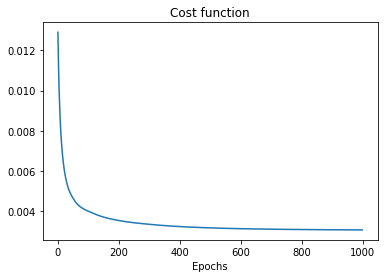

In [3]:
# Step 1. activate for Gradient Descent on bulk data
X = tf.constant(X_train_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32, name="y")

# # Step 1. activate for mini-batch learning
# batch_size = m//5
# X = tf.placeholder(dtype=tf.float32, shape=(None, 3))
# y = tf.placeholder(dtype=tf.float32, shape=(None, 1))
# def fetch_batch(batch_size, m):
#     index = np.random.choice(m, batch_size)
#     X_batch = X_train_plus_bias[index].astype('float32')
#     y_batch = y_train.reshape(-1, 1)[index].astype('float32')
#     return X_batch, y_batch

# -------------------------------------------------------------------

# Step 2. Define theta vector and output of perseptron
# prepare weights Q.shape = (3, 1). 
theta = tf.Variable(tf.random_uniform([n, 1], -1.0, 1.0, seed=0), name="theta")
# activation function logit
sigmoid = 1 / (1 + tf.exp(-tf.matmul(X, theta)))
# if sigmoid >= 0.5 y_pred is 1; 0 otherwise
y_pred = tf.round(sigmoid)
# learning rate
lr = 0.5

# -------------------------------------------------------------------

# Step 3. Count dQ to be added to vector theta for a second run.
error = (y_train - sigmoid) # for main gradient descent
# error = (y_train - y_pred) * (sigmoid* (1 - sigmoid)) #for back propagation
# error = (y - sigmoid) # for mini-batch gradient descent

# -------------------------------------------------------------------

# Step 4. Choose a function to minimize.
# MSE
mse = tf.reduce_mean(tf.square(error), name='mse')
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Cost function
J = tf.Variable(0, dtype=tf.float32, name="J")
J = -2/m * (tf.reduce_mean(y_pred*tf.log(sigmoid) + (1 - y_pred)*tf.log(1 - sigmoid)))

J_summary = tf.summary.scalar('J', J)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
# --------------------------------------------------------------------

# Step 5. Update gradients and choose training operation
gradients = 2/m * tf.matmul(X, error, transpose_a=True) #bulk gradient descent
# gradients = 2/batch_size * tf.matmul(X, error, transpose_a=True) #mini-batch version
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
# optimizer = tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9)

training_op = tf.assign(theta, theta + lr * gradients)
# training_op = optimizer.minimize(mse)
# training_op = optimizer.minimize(J)

# --------------------------------------------------------------------

epochs = 1000
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    history = []
    sess.run(init)
    for epoch in range(epochs):
        summary_str = J_summary.eval()
        file_writer.add_summary(summary_str, epoch)
        summary_str_mse = mse_summary.eval()
        file_writer.add_summary(summary_str_mse, epoch)
        
# #         activate for mini-batch learning
#         X_batch, y_batch = fetch_batch(batch_size, m)
#         sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
# #         history.append(J.eval(feed_dict={X: X_batch, y: y_batch}))
# #         history.append(mse.eval(feed_dict={X: X_batch, y: y_batch}))
        
# #         activate for MSE
#         history.append(mse.eval())
#         sess.run(training_op)

#         activate for cost function
        history.append(J.eval())
        sess.run(training_op)
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/moons_final.ckpt")
    
print(best_theta)  
file_writer.close()

# get accuracy score on test data
X_test = tf.constant(X_test_plus_bias, dtype=tf.float32, name="X_test")
sigmoid_test = 1 / (1 + tf.exp(-tf.matmul(X_test, best_theta)))
y_pred_test = tf.round(sigmoid_test)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    y_pred_test = y_pred_test.eval()
    
accuracy = ((len(y_test) - np.add.reduce(abs(y_test - y_pred_test))) / len(y_test))[0]
print("y_test: \n{}".format(y_test.reshape(1, -1)))
print("y_pred_test: \n{}".format(y_pred_test.reshape(1, -1)))
print("accuracy {}: ".format(accuracy))
    
# # activate for MSE plot
# plt.figure()
# plt.title("MSE")
# plt.xlabel("Epochs")
# plt.plot(range(epochs), history)
# plt.show()

# activate for cost function plot
plt.figure()
plt.title("Cost function")
plt.xlabel("Epochs")
plt.plot(range(epochs), history)
plt.show()

In [4]:

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "/tmp/moons_final.ckpt")
    
print(best_theta)    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/moons_final.ckpt
[[ 0.80099726]
 [ 1.4735812 ]
 [-6.3388743 ]]
